# Caching in Spark
- It is method in which a particular dataset is stored in memory or disk or both
- The idea is to reuse the dataframe

In [1]:
from pyspark.storagelevel import StorageLevel
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [2]:
spark = (SparkSession
        .builder
        .appName("caching")
        .config("spark.driver.memory", "10g")
        .config("spark.sql.files.maxPartitionBytes", "268435456")
        .master("local[*]")
        .getOrCreate()
        )

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
customers_file = "customers.parquet"
df_customers = spark.read.parquet(customers_file)
df_customers.show(5)

+----------+-------------+---+------+----------+-----+-----------+
|   cust_id|         name|age|gender|  birthday|  zip|       city|
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9| Aaron Abbott| 34|Female| 7/13/1991|97823|     boston|
|C00B971T1J| Aaron Austin| 37|Female|12/16/2004|30332|    chicago|
|C00WRSJF1Q| Aaron Barnes| 29|Female| 3/11/1977|23451|     denver|
|C01AZWQMF3|Aaron Barrett| 31|  Male|  7/9/1998|46613|los_angeles|
|C01BKUFRHA| Aaron Becker| 54|  Male|11/24/1979|40284|  san_diego|
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



#### Let's create a base dataframe that would be used for several operations downstream

In [4]:
df_base = (
    df_customers.filter(F.col("city")=="boston")
    .withColumn("age_group",
               F.when(F.col("age").between(20,30), "young")
                .when(F.col("age").between(31,50), "mid")
                .when(F.col("age")>51, "old")
                .otherwise("kid")
               )
    .select("cust_id", "name", "age", "gender", "birthday", "zip", "age_group")
)

df_base.show(5, False)

+----------+--------------+---+------+---------+-----+---------+
|cust_id   |name          |age|gender|birthday |zip  |age_group|
+----------+--------------+---+------+---------+-----+---------+
|C007YEYTX9|Aaron Abbott  |34 |Female|7/13/1991|97823|mid      |
|C08XAQUY73|Aaron Lambert |54 |Female|11/5/1966|75218|old      |
|C094P1VXF9|Aaron Lindsey |24 |Male  |9/21/1990|29399|young    |
|C097SHE1EF|Aaron Lopez   |22 |Female|4/18/2001|82129|young    |
|C0DTC6436T|Aaron Schwartz|52 |Female|7/9/1962 |57192|old      |
+----------+--------------+---+------+---------+-----+---------+
only showing top 5 rows



In [5]:
# using df_base for creating df_1
df_1 = df_base.withColumn("test_column", F.lit("test_1"))\
                .withColumn("birth_year", F.year("birthday"))

df_1.show(5)

+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|   cust_id|          name|age|gender| birthday|  zip|age_group|test_column|birth_year|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|C007YEYTX9|  Aaron Abbott| 34|Female|7/13/1991|97823|      mid|     test_1|      NULL|
|C08XAQUY73| Aaron Lambert| 54|Female|11/5/1966|75218|      old|     test_1|      NULL|
|C094P1VXF9| Aaron Lindsey| 24|  Male|9/21/1990|29399|    young|     test_1|      NULL|
|C097SHE1EF|   Aaron Lopez| 22|Female|4/18/2001|82129|    young|     test_1|      NULL|
|C0DTC6436T|Aaron Schwartz| 52|Female| 7/9/1962|57192|      old|     test_1|      NULL|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
only showing top 5 rows



In [6]:
df_1.explain(mode='formatted')

== Physical Plan ==
* Project (4)
+- * Filter (3)
   +- * ColumnarToRow (2)
      +- Scan parquet  (1)


(1) Scan parquet 
Output [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]
Batched: true
Location: InMemoryFileIndex [file:/home/jovyan/customers.parquet]
PushedFilters: [IsNotNull(city), EqualTo(city,boston)]
ReadSchema: struct<cust_id:string,name:string,age:string,gender:string,birthday:string,zip:string,city:string>

(2) ColumnarToRow [codegen id : 1]
Input [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]

(3) Filter [codegen id : 1]
Input [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]
Condition : (isnotnull(city#6) AND (city#6 = boston))

(4) Project [codegen id : 1]
Output [9]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) TH

**Notice that in the Project step, Spark calculates the age group and in the filter step applies filter for city = boston. These operations belong to df_base, which are essentially getting repeated**

In [7]:
# lets create another dataframe from df_base
df_2 = df_base.withColumn("test_column", F.lit("test_2"))\
                .withColumn("birth_month", F.month("birthday"))
df_2.show(5)

+----------+--------------+---+------+---------+-----+---------+-----------+-----------+
|   cust_id|          name|age|gender| birthday|  zip|age_group|test_column|birth_month|
+----------+--------------+---+------+---------+-----+---------+-----------+-----------+
|C007YEYTX9|  Aaron Abbott| 34|Female|7/13/1991|97823|      mid|     test_2|       NULL|
|C08XAQUY73| Aaron Lambert| 54|Female|11/5/1966|75218|      old|     test_2|       NULL|
|C094P1VXF9| Aaron Lindsey| 24|  Male|9/21/1990|29399|    young|     test_2|       NULL|
|C097SHE1EF|   Aaron Lopez| 22|Female|4/18/2001|82129|    young|     test_2|       NULL|
|C0DTC6436T|Aaron Schwartz| 52|Female| 7/9/1962|57192|      old|     test_2|       NULL|
+----------+--------------+---+------+---------+-----+---------+-----------+-----------+
only showing top 5 rows



In [8]:
df_2.explain(mode='formatted')

== Physical Plan ==
* Project (4)
+- * Filter (3)
   +- * ColumnarToRow (2)
      +- Scan parquet  (1)


(1) Scan parquet 
Output [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]
Batched: true
Location: InMemoryFileIndex [file:/home/jovyan/customers.parquet]
PushedFilters: [IsNotNull(city), EqualTo(city,boston)]
ReadSchema: struct<cust_id:string,name:string,age:string,gender:string,birthday:string,zip:string,city:string>

(2) ColumnarToRow [codegen id : 1]
Input [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]

(3) Filter [codegen id : 1]
Input [7]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, city#6]
Condition : (isnotnull(city#6) AND (city#6 = boston))

(4) Project [codegen id : 1]
Output [9]: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) TH

**Here as well the same pattern can be seen where df_base is recalculated.**

- This is because Spark uses Lazy Evaluation - only performing transformations when they are called, before that it only creates a plan of how it's going to execute in the most optimal way
- This is where **caching** comes in, where you store df_base in memory which means that Spark does not need to recalc. it again

#### Caching df_base

In [9]:
df_base = (
    df_customers.filter(F.col("city")=="boston")
    .withColumn("age_group",
               F.when(F.col("age").between(20,30), "young")
                .when(F.col("age").between(31,50), "mid")
                .when(F.col("age")>51, "old")
                .otherwise("kid")
               )
    .select("cust_id", "name", "age", "gender", "birthday", "zip", "age_group")
)

df_base.cache()
df_base.show(5)

+----------+--------------+---+------+---------+-----+---------+
|   cust_id|          name|age|gender| birthday|  zip|age_group|
+----------+--------------+---+------+---------+-----+---------+
|C007YEYTX9|  Aaron Abbott| 34|Female|7/13/1991|97823|      mid|
|C08XAQUY73| Aaron Lambert| 54|Female|11/5/1966|75218|      old|
|C094P1VXF9| Aaron Lindsey| 24|  Male|9/21/1990|29399|    young|
|C097SHE1EF|   Aaron Lopez| 22|Female|4/18/2001|82129|    young|
|C0DTC6436T|Aaron Schwartz| 52|Female| 7/9/1962|57192|      old|
+----------+--------------+---+------+---------+-----+---------+
only showing top 5 rows



In [10]:
# using df_base for creating df_1
df_1 = df_base.withColumn("test_column", F.lit("test_1"))\
                .withColumn("birth_year", F.year("birthday"))

df_1.show(5)

+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|   cust_id|          name|age|gender| birthday|  zip|age_group|test_column|birth_year|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|C007YEYTX9|  Aaron Abbott| 34|Female|7/13/1991|97823|      mid|     test_1|      NULL|
|C08XAQUY73| Aaron Lambert| 54|Female|11/5/1966|75218|      old|     test_1|      NULL|
|C094P1VXF9| Aaron Lindsey| 24|  Male|9/21/1990|29399|    young|     test_1|      NULL|
|C097SHE1EF|   Aaron Lopez| 22|Female|4/18/2001|82129|    young|     test_1|      NULL|
|C0DTC6436T|Aaron Schwartz| 52|Female| 7/9/1962|57192|      old|     test_1|      NULL|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
only showing top 5 rows



In [11]:
df_1.explain(mode='formatted')

== Physical Plan ==
AdaptiveSparkPlan (8)
+- Project (7)
   +- InMemoryTableScan (1)
         +- InMemoryRelation (2)
               +- * Project (6)
                  +- * Filter (5)
                     +- * ColumnarToRow (4)
                        +- Scan parquet  (3)


(1) InMemoryTableScan
Output [7]: [age#2, age_group#201, birthday#4, cust_id#0, gender#3, name#1, zip#5]
Arguments: [age#2, age_group#201, birthday#4, cust_id#0, gender#3, name#1, zip#5]

(2) InMemoryRelation
Arguments: [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, age_group#201], CachedRDDBuilder(org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer@4434198b,StorageLevel(disk, memory, deserialized, 1 replicas),*(1) Project [cust_id#0, name#1, age#2, gender#3, birthday#4, zip#5, CASE WHEN ((cast(age#2 as int) >= 20) AND (cast(age#2 as int) <= 30)) THEN young WHEN ((cast(age#2 as int) >= 31) AND (cast(age#2 as int) <= 50)) THEN mid WHEN (cast(age#2 as int) > 51) THEN old ELSE kid END AS age_g

- The DAG confirms that the Parquet file isn't being scanned because the relevant data has already been loaded into memory and cached. The operations are leveraging Spark's in-memory optimization, which avoids redundant scans of the underlying Parquet data. Instead, the focus is on processing data directly from the in-memory representation.

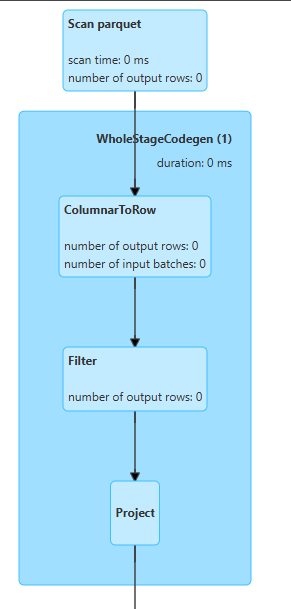

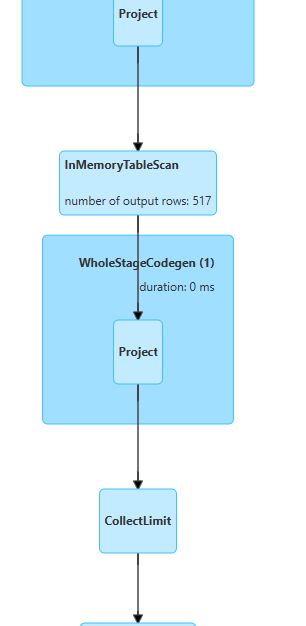




### **1. Non-Cached Plan**
- **Lazy Evaluation:** In the non-cached plan, Spark evaluates the transformations (e.g., filtering, adding columns) whenever the DataFrame is accessed. 
- **Repeated Computation:** 
  - The filtering (`city == 'boston'`) and the computation of the `age_group` column are repeated every time the DataFrame (`df_base`) is used.
  - In this case, the `df_1` DataFrame requires the `df_base` DataFrame, so the entire pipeline is recomputed from the source each time.

#### Key Observations:
- **`Filter` Step (3):**
  - Filters the data where `city = 'boston'`.
- **`Project` Step (4):**
  - Computes the `age_group` column, along with other transformations.
- Both steps are re-applied each time `df_base` is used.
  
---

### **2. Cached Plan**
- **Materialized Intermediate Results:** When you use `cache()`, Spark materializes the intermediate result of `df_base` in memory (or disk if necessary).
- **Reuses Cached Data:** After caching, subsequent transformations on `df_base` don't recompute the original steps (filtering, age group computation). Instead, they directly use the precomputed results stored in memory.

#### Key Observations:
- **`InMemoryRelation` (2):**
  - Represents the cached result of `df_base`. This stores the filtered and transformed data in memory.
  - The `age_group` computation and filtering (`city == 'boston'`) are performed only once during the initial materialization.
- **`InMemoryTableScan` (1):**
  - Fetches the precomputed data from memory when `df_base` is reused in `df_1`.

---

### **Key Differences**
| Feature                 | Non-Cached Plan                                                                                                     | Cached Plan                                                                                                         |
|-------------------------|---------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------|
| **Recomputation**        | Recomputes transformations (`filter`, `age_group`) every time `df_base` is used.                                    | Does not recompute; directly uses the cached result of `df_base`.                                                  |
| **Execution Steps**      | Includes `Scan -> Filter -> Project` every time `df_base` is accessed.                                              | Includes `InMemoryRelation -> InMemoryTableScan` for retrieving precomputed results.                               |
| **Performance**          | Slower, as the same operations are performed repeatedly.                                                           | Faster, as results are fetched directly from memory.                                                               |
| **Caching Layer**        | Not used; Spark only plans the computation without storing intermediate results.                                    | Uses `InMemoryRelation`, which stores the intermediate result of `df_base`.                                        |

---

### **Why Cache Improves Performance**
1. **Avoids Redundant Computation:** The cached plan ensures that Spark doesn't re-run the expensive steps of filtering and column computation.
2. **Optimized Reuse:** Cached data is optimized for repeated access, which is especially useful in iterative workloads or when a DataFrame is used in multiple places (e.g., `df_base` in this case).

### **When to Use Cache?**
- When a DataFrame is reused multiple times in downstream transformations.
- When intermediate resu help with any specific concepts or optimizations?

## StorageLevel Types in Spark
(As of Spark 3.4)`

DISK_O` NLY: CPU efficient, memory efficient, slow to access, data is serialized when stored on dis`k

DISK_O` NLY_2: disk only, replicated` 2x

DISK` _ONLY_3: disk only, replicat`ed 3x

MEMORY` _AND_DISK: spills to disk if there's no space in` memory

MEMORY` _AND_DISK_2: memory and disk, repl`icated 2x

MEMORY_AND_DISK_D` ESER(default): same as MEMORY_AND_DISK, deserialized in both for `fast access` 

MEMORY_ONLY: CPU efficient, mem`ory intensive` 

MEMORY_ONLY_2: memory only, replicated 2x - for resilience, if o

### Cache Vs Persist
- In Spark you have two method to cache a dataframe
    - with df.cache() you cannot change the StorageLevel it is by default `DISK_AND_MEMORY`
    - with df.persist(STORAGE_LEVEL) you can assign the StorageLevelne executor fails

In [15]:
df_base.unpersist() #uncache
df_base.persist(StorageLevel.MEMORY_AND_DISK)

df_1 = df_base.withColumn("test_column", F.lit("test_1"))\
                .withColumn("birth_year", F.year("birthday"))

df_1.show(5)

+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|   cust_id|          name|age|gender| birthday|  zip|age_group|test_column|birth_year|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
|C007YEYTX9|  Aaron Abbott| 34|Female|7/13/1991|97823|      mid|     test_1|      NULL|
|C08XAQUY73| Aaron Lambert| 54|Female|11/5/1966|75218|      old|     test_1|      NULL|
|C094P1VXF9| Aaron Lindsey| 24|  Male|9/21/1990|29399|    young|     test_1|      NULL|
|C097SHE1EF|   Aaron Lopez| 22|Female|4/18/2001|82129|    young|     test_1|      NULL|
|C0DTC6436T|Aaron Schwartz| 52|Female| 7/9/1962|57192|      old|     test_1|      NULL|
+----------+--------------+---+------+---------+-----+---------+-----------+----------+
only showing top 5 rows



- Using the Spark UI Storage Tab you can see the cached objects

### Disk Only
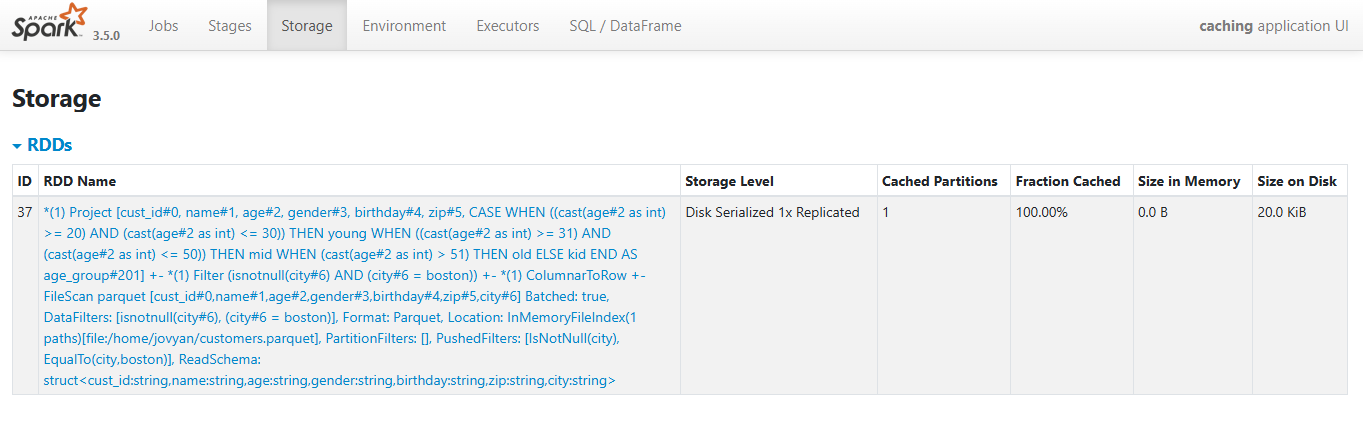

### Disk Only 2 (basically Store 2 Copies)
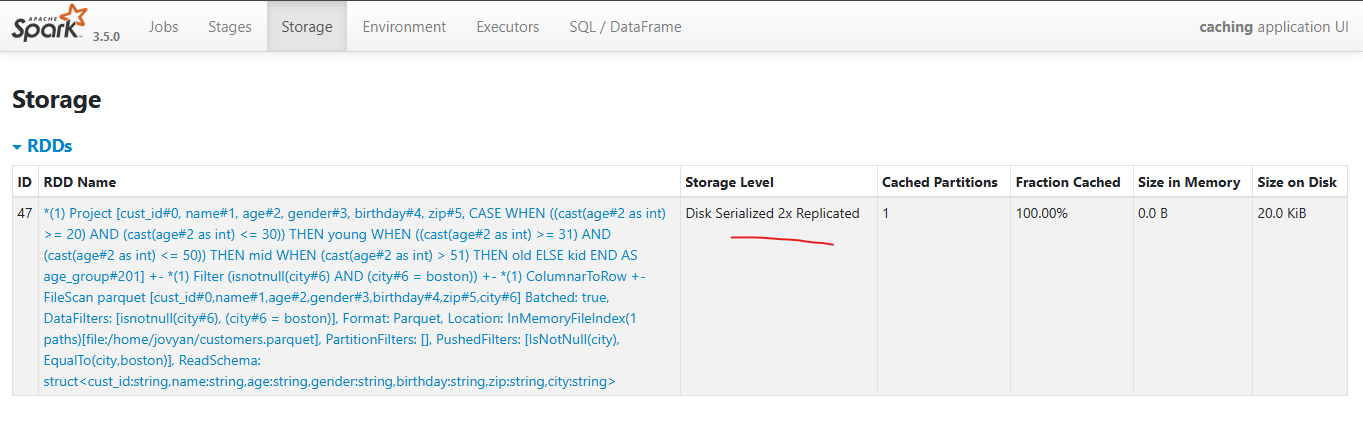

### Memory and Disk
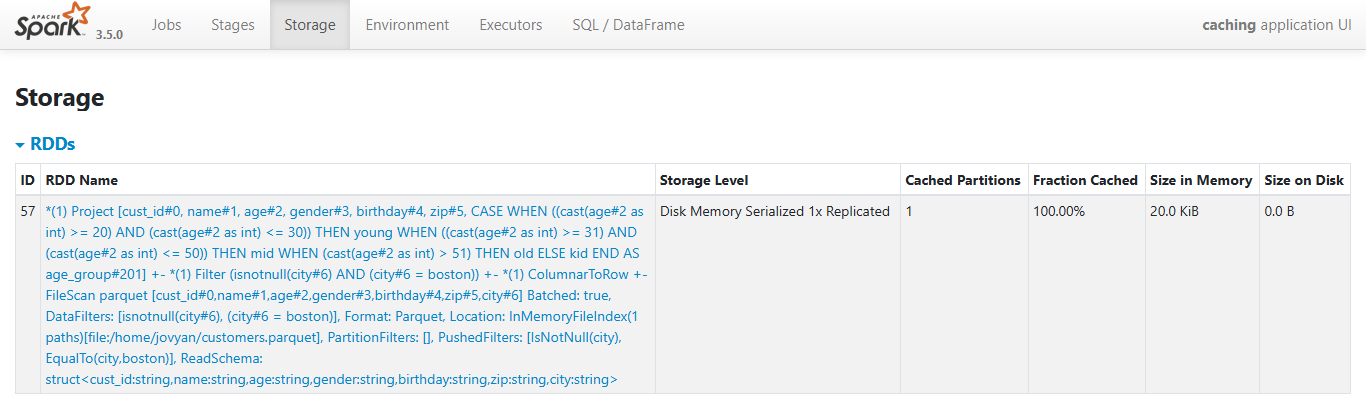



- **SER** (Serialization) is CPU-intensive but saves memory as data is compact.  
- **DESER** (Deserialization) is CPU-efficient but memory-intensive.  
- The size of data on disk is smaller because it's stored in a serialized format. When loaded into memory, it is deserialized into JVM objects for faster access#.

## When to Use What?

| **Storage Level**      | **Space Used** | **CPU Time** | **In Memory** | **On Disk** | **Serialized** |
|-------------------------|----------------|--------------|---------------|-------------|----------------|
| **MEMORY_ONLY**         | High           | Low          | Yes           | No          | No             |
| **MEMORY_ONLY_SER**     | Low            | High         | Yes           | No          | Yes            |
| **MEMORY_AND_DISK**     | High           | Medium       | Some          | Some        | Some           |
| **MEMORY_AND_DISK_SER** | Low            | High         | Some          | Some        | Yes            |
| **DISK_ONLY**           | Low            | High         | No            | Yes         | Y          |
```


1. **MEMORY_ONLY**  
   - Stores data only in memory as deserialized JVM objects.  
   - Fastest for data access (low CPU usage) but uses the most memory.  
   - If memory is insufficient, data will not be cached to disk, and recomputation will occur.

2. **MEMORY_ONLY_SER**  
   - Stores data in memory in a serialized format.  
   - Saves memory compared to `MEMORY_ONLY` but requires more CPU time for serialization and deserialization.  
   - Suitable for large datasets when memory is a concern.

3. **MEMORY_AND_DISK**  
   - Stores data in memory (deserialized) and falls back to disk if memory is insufficient.  
   - Balances memory usage and data availability.  
   - Some serialization happens when data moves between memory and disk.

4. **MEMORY_AND_DISK_SER**  
   - Similar to `MEMORY_AND_DISK` but stores data in serialized form both in memory and on disk.  
   - Saves memory but increases CPU usage for serialization and deserialization.  
   - Ideal for large datasets that don't fit in memory.

5. **DISK_ONLY**  
   - Stores data only on disk in a serialized format.  
   - Saves the most memory but has the highest CPU cost and slowest data access.  
   - Used when memory is extremely limited or data is infrequently accessed. 

### Summary:
- Use `MEMORY_ONLY` for the fastest access if memory is sufficient.
- Use `MEMORY_ONLY_SER` or `MEMORY_AND_DISK_SER` for large datasets to save memory.
- Use `DISK_ONLY` as a fallback for limited memory or rarely accessed data.



### **1. Serialization**  
- **Definition**: The process of converting data (e.g., objects, structures) into a compact binary format or byte stream.  
- **Purpose**: To efficiently store or transfer data. For example:
  - Writing data to disk.
  - Sending data over a network.
  - Storing large datasets in memory in a compact format.
- **Advantages**:
  - Saves memory as serialized data is more compact.
  - Can be written to disk or transferred across systems.
- **Disadvantages**:
  - Accessing or processing serialized data requires **deserialization**, which uses CPU resources.

---

### **2. Deserialization**  
- **Definition**: The reverse process of converting serialized data back into its original format (e.g., objects in memory).  
- **Purpose**: To make the data usable for computation (e.g., applying Spark transformations).  
- **Advantages**:
  - Enables faster processing since deserialized data is stored in memory as native **JVM objects** (ready to use).
- **Disadvantages**:
  - Uses more memory because deserialized data takes up more space than its serialized counterpart.

---

### **In Spark Context**
- **Serialized Data**:
  - Stored in a compact format.
  - Saves memory but requires CPU for serialization and deserialization.
  - Used when memory is limited.
  
- **Deserialized Data**:
  - Stored as native JVM objects in memory.
  - Faster to access and process but uses more memory.
  - Preferred for small to medium datasets where memory is sufficient.

---

### **Example in Spark Storage Levels**
- **`MEMORY_ONLY`**: Data is deserialized and stored as JVM objects for fast access.  
- **`MEMORY_ONLY_SER`**: Data is serialized to save memory but needs deserialization for processing.  

Think of serialization as "packing" the data tightly for storage, and deserialization as "unpacking" it for use.